In [1]:
import pandas as pd
import numpy as np
from statsforecast.core import StatsForecast
from statsforecast.models import AutoMFLES, HoltWinters, AutoARIMA, MSTL, AutoETS
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import joblib

/Users/huy-nvq/Personal/Thesis - MinhMD/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv("dataset/SCR-MER-hebdo-A15-23_ENGLISH.csv")
df['ds'] = pd.to_datetime(df['Week'].astype(str) + '-1', format='%GW%V-%u')
df = df[["AuctionHouse", "FAO_Code", "Quantity", "ds"]]
df = df.rename(columns={'Quantity': 'y'})
df

,AuctionHouse,FAO_Code,y,ds
0,Agde,BSS,136.39,2014-12-29
1,Agde,CTC,75.63,2014-12-29
2,Agde,NSQ,462.63,2014-12-29
3,Agde,OCC,373.20,2014-12-29
4,Arcachon,BLL,128.20,2014-12-29
...,...,...,...,...
417520,Sète,SWA,47.20,2023-03-20
417521,Sète,SYC,156.80,2023-03-20
417522,Sète,TUR,26.20,2023-03-20
417523,Sète,UUC,128.20,2023-03-20


In [25]:
min_date = df['ds'].min()
max_date = df['ds'].max()
full_range = pd.date_range(start=min_date, end=max_date, freq='W-MON')
expected_weeks = len(full_range)
series_stats = df.groupby(['FAO_Code', 'AuctionHouse'])['ds'].nunique()
complete_ids = series_stats[series_stats == expected_weeks].index
df_clean = df.set_index(['FAO_Code', 'AuctionHouse']).loc[complete_ids].reset_index()
df_final = df_clean.sort_values(by=['FAO_Code', 'AuctionHouse', 'ds']).reset_index(drop=True)
df_final

,FAO_Code,AuctionHouse,y,ds
0,BIB,Boulogne,3272.0,2014-12-29
1,BIB,Boulogne,12794.5,2015-01-05
2,BIB,Boulogne,5989.0,2015-01-12
3,BIB,Boulogne,31547.5,2015-01-19
4,BIB,Boulogne,19322.0,2015-01-26
...,...,...,...,...
15475,WHG,Lorient,2281.5,2023-02-20
15476,WHG,Lorient,2562.3,2023-02-27
15477,WHG,Lorient,1599.0,2023-03-06
15478,WHG,Lorient,1257.3,2023-03-13


In [26]:
spec = [
    ['FAO_Code'],
    ['AuctionHouse'],             
    ['FAO_Code', 'AuctionHouse'] 
]
Y_df, S_df, tags = aggregate(df_final, spec)
Y_df = Y_df.reset_index()


In [27]:
Y_df

,index,unique_id,ds,y
0,0,BIB,2014-12-29,4523.40
1,1,BIB,2015-01-05,15728.00
2,2,BIB,2015-01-12,8191.70
3,3,BIB,2015-01-19,37368.02
4,4,BIB,2015-01-26,21823.30
...,...,...,...,...
28375,28375,WHG/Lorient,2023-02-20,2281.50
28376,28376,WHG/Lorient,2023-02-27,2562.30
28377,28377,WHG/Lorient,2023-03-06,1599.00
28378,28378,WHG/Lorient,2023-03-13,1257.30


NameError: name 'Y_fitted' is not defined

In [28]:
Y_train = Y_df[Y_df['ds'].dt.year < 2022].copy()
Y_test  = Y_df[Y_df['ds'].dt.year >= 2022].copy()
Y_train = Y_train[['unique_id', 'ds', 'y']].copy()
Y_test = Y_test[['unique_id', 'ds', 'y']].copy()
horizon = Y_test['ds'].nunique()

In [29]:
fcst = StatsForecast(
    models=[
        HoltWinters(season_length=52, alias="HW"),
        AutoARIMA(season_length=52, alias="ARIMA")
    ], 
    freq='W-MON',
    n_jobs=-1
)

In [30]:
weights = {'HW': 0.6, 'ARIMA': 0.4}

In [31]:
Y_hat_df = fcst.forecast(h=horizon, df=Y_train, fitted=True)

In [77]:
fcst.fit(df=Y_train)

StatsForecast(models=[HW,ARIMA])

In [35]:
Y_fitted_df = fcst.forecast_fitted_values()

In [123]:
Y_fitted_df

,unique_id,ds,y,HW,ARIMA,Ensemble
0,BIB,2014-12-29,4523.40,6008.556563,4518.876604,5412.684579
1,BIB,2015-01-05,15728.00,13542.214199,15712.272015,14410.237325
2,BIB,2015-01-12,8191.70,22296.559776,8183.508317,16651.339193
3,BIB,2015-01-19,37368.02,20476.525373,37330.652026,27218.176034
4,BIB,2015-01-26,21823.30,22123.398369,21801.476752,21994.629722
...,...,...,...,...,...,...
24151,WHG/Lorient,2021-11-29,3405.60,4793.498967,3116.165306,4122.565503
24152,WHG/Lorient,2021-12-06,2229.36,3209.764986,3010.663190,3130.124268
24153,WHG/Lorient,2021-12-13,3104.72,2209.854071,2392.529460,2282.924226
24154,WHG/Lorient,2021-12-20,3205.30,688.479124,2801.482626,1533.680525


In [79]:
Y_hat_df['Ensemble'] = (
    Y_hat_df['HW'] * weights['HW'] + 
    Y_hat_df['ARIMA'] * weights['ARIMA']
)

In [37]:
Y_fitted_df

,unique_id,ds,y,HW,ARIMA
0,BIB,2014-12-29,4523.40,6008.556563,4518.876604
1,BIB,2015-01-05,15728.00,13542.214199,15712.272015
2,BIB,2015-01-12,8191.70,22296.559776,8183.508317
3,BIB,2015-01-19,37368.02,20476.525373,37330.652026
4,BIB,2015-01-26,21823.30,22123.398369,21801.476752
...,...,...,...,...,...
24151,WHG/Lorient,2021-11-29,3405.60,4793.498967,3116.165306
24152,WHG/Lorient,2021-12-06,2229.36,3209.764986,3010.663190
24153,WHG/Lorient,2021-12-13,3104.72,2209.854071,2392.529460
24154,WHG/Lorient,2021-12-20,3205.30,688.479124,2801.482626


In [125]:
Y_fitted_df

,unique_id,ds,y,HW,ARIMA,Ensemble
0,BIB,2014-12-29,4523.40,6008.556563,4518.876604,5412.684579
1,BIB,2015-01-05,15728.00,13542.214199,15712.272015,14410.237325
2,BIB,2015-01-12,8191.70,22296.559776,8183.508317,16651.339193
3,BIB,2015-01-19,37368.02,20476.525373,37330.652026,27218.176034
4,BIB,2015-01-26,21823.30,22123.398369,21801.476752,21994.629722
...,...,...,...,...,...,...
24151,WHG/Lorient,2021-11-29,3405.60,4793.498967,3116.165306,4122.565503
24152,WHG/Lorient,2021-12-06,2229.36,3209.764986,3010.663190,3130.124268
24153,WHG/Lorient,2021-12-13,3104.72,2209.854071,2392.529460,2282.924226
24154,WHG/Lorient,2021-12-20,3205.30,688.479124,2801.482626,1533.680525


In [127]:
Y_fitted_df

,unique_id,ds,y,HW,ARIMA,Ensemble
0,BIB,2014-12-29,4523.40,6008.556563,4518.876604,5412.684579
1,BIB,2015-01-05,15728.00,13542.214199,15712.272015,14410.237325
2,BIB,2015-01-12,8191.70,22296.559776,8183.508317,16651.339193
3,BIB,2015-01-19,37368.02,20476.525373,37330.652026,27218.176034
4,BIB,2015-01-26,21823.30,22123.398369,21801.476752,21994.629722
...,...,...,...,...,...,...
24151,WHG/Lorient,2021-11-29,3405.60,4793.498967,3116.165306,4122.565503
24152,WHG/Lorient,2021-12-06,2229.36,3209.764986,3010.663190,3130.124268
24153,WHG/Lorient,2021-12-13,3104.72,2209.854071,2392.529460,2282.924226
24154,WHG/Lorient,2021-12-20,3205.30,688.479124,2801.482626,1533.680525


In [80]:
Y_fitted_df['Ensemble'] = (
    Y_fitted_df['HW'] * weights['HW'] + 
    Y_fitted_df['ARIMA'] * weights['ARIMA']
)

In [ ]:
joblib.dump(Y_fitted_df[['unique_id','ds','y', 'Ensemble']], 
            "/Users/huy-nvq/Personal/Thesis - MinhMD/seafood-demand-forecasting-server/artifacts/Y_fitted_ensemble.pkl")
joblib.dump(fcst, "/Users/huy-nvq/Personal/Thesis - MinhMD/seafood-demand-forecasting-server/artifacts/fcst_model.pkl")
joblib.dump(S_df, "/Users/huy-nvq/Personal/Thesis - MinhMD/seafood-demand-forecasting-server/artifacts/S_df.pkl")
joblib.dump(tags, "/Users/huy-nvq/Personal/Thesis - MinhMD/seafood-demand-forecasting-server/artifacts/tags.pkl")
joblib.dump(Y_train, "/Users/huy-nvq/Personal/Thesis - MinhMD/seafood-demand-forecasting-server/artifacts/Y_train_history.pkl")

['/Users/huy-nvq/Personal/Thesis - MinhMD/seafood-demand-forecasting-server/artifacts/Y_train_history.pkl']

In [112]:
Y_test

,unique_id,ds,y
366,BIB,2022-01-03,26372.60
367,BIB,2022-01-10,29631.90
368,BIB,2022-01-17,19955.90
369,BIB,2022-01-24,17413.25
370,BIB,2022-01-31,20987.50
...,...,...,...
28375,WHG/Lorient,2023-02-20,2281.50
28376,WHG/Lorient,2023-02-27,2562.30
28377,WHG/Lorient,2023-03-06,1599.00
28378,WHG/Lorient,2023-03-13,1257.30


In [111]:
joblib.dump(Y_test, "/Users/huy-nvq/Personal/Thesis - MinhMD/seafood-demand-forecasting-server/artifacts/Y_test.pkl")

['/Users/huy-nvq/Personal/Thesis - MinhMD/seafood-demand-forecasting-server/artifacts/Y_test.pkl']

In [115]:
Y_test

,unique_id,ds,y
366,BIB,2022-01-03,26372.60
367,BIB,2022-01-10,29631.90
368,BIB,2022-01-17,19955.90
369,BIB,2022-01-24,17413.25
370,BIB,2022-01-31,20987.50
...,...,...,...
28375,WHG/Lorient,2023-02-20,2281.50
28376,WHG/Lorient,2023-02-27,2562.30
28377,WHG/Lorient,2023-03-06,1599.00
28378,WHG/Lorient,2023-03-13,1257.30


In [47]:
Y_hat_ens = Y_hat_df[['unique_id', 'ds', 'Ensemble']].rename(columns={'Ensemble': 'y'})
Y_fitted_ens = Y_fitted_df[['unique_id', 'ds', 'Ensemble']].rename(columns={'Ensemble': 'y'})
model_name = 'EnsembleModel'
Y_hat_ens = Y_hat_ens.rename(columns={'y': model_name})
Y_fitted_ens = Y_fitted_ens.rename(columns={'y': model_name})

In [48]:
reconcilers = [
    BottomUp(),
    MinTrace(method='ols'),
    MinTrace(method='mint_shrink'),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

In [49]:
Y_rec_df = hrec.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_fitted_df,
    S_df=S_df,
    tags=tags
)

In [50]:
num_cols = Y_rec_df.select_dtypes(include=[np.number]).columns
Y_rec_df[num_cols] = Y_rec_df[num_cols].clip(lower=0)

In [119]:
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).

    Args:
        y_true (array-like): True or actual values.
        y_pred (array-like): Predicted values.

    Returns:
        float: The calculated SMAPE value.
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    epsilon = np.finfo(np.float64).eps
    denominator[denominator == 0] = epsilon 

    percentage_error = numerator / denominator
    smape_value = np.mean(percentage_error) * 100
    return smape_value

In [ ]:
df_eval = Y_rec_df.merge(Y_test[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='inner')

In [97]:
df_eval

,unique_id,ds,HW,ARIMA,Ensemble,HW/BottomUp,ARIMA/BottomUp,Ensemble/BottomUp,HW/MinTrace_method-ols,ARIMA/MinTrace_method-ols,Ensemble/MinTrace_method-ols,HW/MinTrace_method-mint_shrink,ARIMA/MinTrace_method-mint_shrink,Ensemble/MinTrace_method-mint_shrink,y
0,BIB,2022-01-03,18409.332261,20656.096185,19308.037830,18585.824865,19041.700459,18768.175103,18377.904548,19196.062921,18705.167897,18643.611600,18825.917607,19254.773230,26372.60
1,BIB,2022-01-10,16878.474713,16769.364180,16834.830500,16732.404607,15724.858514,16329.386170,16796.406845,16277.559284,16588.867821,17000.920243,16108.849157,16775.276052,29631.90
2,BIB,2022-01-17,18211.868834,16578.502110,17558.522145,18347.772548,15928.325292,17379.993646,18232.244187,16087.698322,17374.425841,18450.815912,16575.191230,17795.068471,19955.90
3,BIB,2022-01-24,15136.120048,15902.338632,15442.607482,15274.946468,14376.591430,14915.604453,15131.334314,15038.231756,15094.093291,15393.965071,14834.808504,15270.416568,17413.25
4,BIB,2022-01-31,13125.286365,14389.698362,13631.051164,13106.801844,13162.023759,13128.890610,13134.874716,13600.897840,13321.283965,13334.405331,13461.591054,13448.187018,20987.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,WHG/Lorient,2023-02-20,4449.640801,3824.323996,4199.514079,4449.640801,3824.323996,4199.514079,4673.235086,2977.674066,3995.010678,4775.675122,4276.925833,4346.936928,2281.50
4220,WHG/Lorient,2023-02-27,4266.913051,3824.262049,4089.852650,4266.913051,3824.262049,4089.852650,4366.514996,3568.037621,4047.124046,4441.405301,3981.602623,4158.671497,2562.30
4221,WHG/Lorient,2023-03-06,4683.315241,3824.243854,4339.686686,4683.315241,3824.243854,4339.686686,4783.097104,3537.916055,4285.024685,4871.312277,3966.534049,4339.193819,1599.00
4222,WHG/Lorient,2023-03-13,4258.175337,3824.238510,4084.600606,4258.175337,3824.238510,4084.600606,4234.567131,3645.323551,3998.869699,4298.357997,3845.956848,4044.783783,1257.30


In [90]:
df_eval

,unique_id,ds,HW,ARIMA,Ensemble,HW/BottomUp,ARIMA/BottomUp,Ensemble/BottomUp,HW/MinTrace_method-ols,ARIMA/MinTrace_method-ols,Ensemble/MinTrace_method-ols,HW/MinTrace_method-mint_shrink,ARIMA/MinTrace_method-mint_shrink,Ensemble/MinTrace_method-mint_shrink,y
0,BIB,2022-01-03,18409.332261,20656.096185,19308.037830,18585.824865,19041.700459,18768.175103,18377.904548,19196.062921,18705.167897,18643.611600,18825.917607,19254.773230,26372.60
1,BIB,2022-01-10,16878.474713,16769.364180,16834.830500,16732.404607,15724.858514,16329.386170,16796.406845,16277.559284,16588.867821,17000.920243,16108.849157,16775.276052,29631.90
2,BIB,2022-01-17,18211.868834,16578.502110,17558.522145,18347.772548,15928.325292,17379.993646,18232.244187,16087.698322,17374.425841,18450.815912,16575.191230,17795.068471,19955.90
3,BIB,2022-01-24,15136.120048,15902.338632,15442.607482,15274.946468,14376.591430,14915.604453,15131.334314,15038.231756,15094.093291,15393.965071,14834.808504,15270.416568,17413.25
4,BIB,2022-01-31,13125.286365,14389.698362,13631.051164,13106.801844,13162.023759,13128.890610,13134.874716,13600.897840,13321.283965,13334.405331,13461.591054,13448.187018,20987.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,WHG/Lorient,2023-02-20,4449.640801,3824.323996,4199.514079,4449.640801,3824.323996,4199.514079,4673.235086,2977.674066,3995.010678,4775.675122,4276.925833,4346.936928,2281.50
4220,WHG/Lorient,2023-02-27,4266.913051,3824.262049,4089.852650,4266.913051,3824.262049,4089.852650,4366.514996,3568.037621,4047.124046,4441.405301,3981.602623,4158.671497,2562.30
4221,WHG/Lorient,2023-03-06,4683.315241,3824.243854,4339.686686,4683.315241,3824.243854,4339.686686,4783.097104,3537.916055,4285.024685,4871.312277,3966.534049,4339.193819,1599.00
4222,WHG/Lorient,2023-03-13,4258.175337,3824.238510,4084.600606,4258.175337,3824.238510,4084.600606,4234.567131,3645.323551,3998.869699,4298.357997,3845.956848,4044.783783,1257.30


In [53]:
evaluation

,level,metric,HW,ARIMA,Ensemble,HW/BottomUp,ARIMA/BottomUp,Ensemble/BottomUp,HW/MinTrace_method-ols,ARIMA/MinTrace_method-ols,Ensemble/MinTrace_method-ols,HW/MinTrace_method-mint_shrink,ARIMA/MinTrace_method-mint_shrink,Ensemble/MinTrace_method-mint_shrink
0,FAO_Code,rmse,5016.883759,5178.654511,4916.071130,4980.760736,5047.075926,4821.983987,5025.691074,5190.714012,4903.250742,4993.611625,5074.092687,4869.298390
1,FAO_Code,smape,0.253174,0.235557,0.234584,0.251881,0.229398,0.231414,0.266688,0.248279,0.233839,0.251579,0.236025,0.231704
2,AuctionHouse,rmse,8634.194173,8803.203741,8361.436051,8580.167945,8744.021389,8350.921624,8616.764097,8713.212056,8350.211446,8591.883202,8569.362784,8328.022940
3,AuctionHouse,smape,0.183450,0.195605,0.181233,0.181874,0.191744,0.178788,0.181943,0.192137,0.177514,0.182607,0.191005,0.179341
4,FAO_Code/AuctionHouse,rmse,3152.644412,3208.469671,3053.812491,3152.644412,3208.469671,3053.812491,3183.059167,3307.328514,3103.378043,3153.538436,3198.644229,3073.347213
5,FAO_Code/AuctionHouse,smape,0.256239,0.246721,0.240893,0.256239,0.246721,0.240893,0.273933,0.293401,0.266481,0.255906,0.251087,0.243161
6,Overall,rmse,4548.103269,4653.182360,4422.318678,4528.971106,4604.343039,4392.214328,4564.721098,4697.124656,4443.768771,4535.128003,4580.707179,4413.737831
7,Overall,smape,0.244281,0.235593,0.229942,0.243651,0.233142,0.228611,0.257800,0.264385,0.243109,0.243489,0.237420,0.230019


In [106]:
from utilsforecast.losses import rmse, smape
from hierarchicalforecast.evaluation import evaluate


evaluation = evaluate(
    df=df_eval,
    train_df=Y_train,
    tags=tags,
    metrics= [rmse, smape],
)
evaluation.set_index(["level", "metric"]).filter(like="Ensemble", axis=1)


Ensemble  Ensemble/BottomUp  \
level                 metric                                   
FAO_Code              rmse    4916.071130        4821.983987   
                      smape      0.234584           0.231414   
AuctionHouse          rmse    8361.436051        8350.921624   
                      smape      0.181233           0.178788   
FAO_Code/AuctionHouse rmse    3053.812491        3053.812491   
                      smape      0.240893           0.240893   
Overall               rmse    4422.318678        4392.214328   
                      smape      0.229942           0.228611   

                              Ensemble/MinTrace_method-ols  \
level                 metric                                 
FAO_Code              rmse                     4903.250742   
                      smape                       0.233839   
AuctionHouse          rmse                     8350.211446   
                      smape                       0.177514   
FAO_Code/AuctionHouse rmse                     3103.378043   
                      smape                       0.266481   
Overall               rmse                     4443.768771   
                      smape                       0.243109   

                              Ensemble/MinTrace_method-mint_shrink  
level                 metric                                        
FAO_Code              rmse                             4869.298390  
                      smape                               0.231704  
AuctionHouse          rmse                             8328.022940  
                      smape                               0.179341  
FAO_Code/AuctionHouse rmse                             3073.347213  
                      smape                               0.243161  
Overall               rmse                             4413.737831  
                      smape                               0.230019

In [100]:
evaluation.set_index(["level", "metric"]).filter(like="HW", axis=1)


HW  HW/BottomUp  \
level                 metric                             
FAO_Code              rmse    5016.883759  4980.760736   
                      smape      0.253174     0.251881   
AuctionHouse          rmse    8634.194173  8580.167945   
                      smape      0.183450     0.181874   
FAO_Code/AuctionHouse rmse    3152.644412  3152.644412   
                      smape      0.256239     0.256239   
Overall               rmse    4548.103269  4528.971106   
                      smape      0.244281     0.243651   

                              HW/MinTrace_method-ols  \
level                 metric                           
FAO_Code              rmse               5025.691074   
                      smape                 0.266688   
AuctionHouse          rmse               8616.764097   
                      smape                 0.181943   
FAO_Code/AuctionHouse rmse               3183.059167   
                      smape                 0.273933   
Overall               rmse               4564.721098   
                      smape                 0.257800   

                              HW/MinTrace_method-mint_shrink  
level                 metric                                  
FAO_Code              rmse                       4993.611625  
                      smape                         0.251579  
AuctionHouse          rmse                       8591.883202  
                      smape                         0.182607  
FAO_Code/AuctionHouse rmse                       3153.538436  
                      smape                         0.255906  
Overall               rmse                       4535.128003  
                      smape                         0.243489

In [102]:
evaluation.set_index(["level", "metric"]).filter(like="ARIMA", axis=1)

ARIMA  ARIMA/BottomUp  \
level                 metric                                
FAO_Code              rmse    5178.654511     5047.075926   
                      smape      0.235557        0.229398   
AuctionHouse          rmse    8803.203741     8744.021389   
                      smape      0.195605        0.191744   
FAO_Code/AuctionHouse rmse    3208.469671     3208.469671   
                      smape      0.246721        0.246721   
Overall               rmse    4653.182360     4604.343039   
                      smape      0.235593        0.233142   

                              ARIMA/MinTrace_method-ols  \
level                 metric                              
FAO_Code              rmse                  5190.714012   
                      smape                    0.248279   
AuctionHouse          rmse                  8713.212056   
                      smape                    0.192137   
FAO_Code/AuctionHouse rmse                  3307.328514   
                      smape                    0.293401   
Overall               rmse                  4697.124656   
                      smape                    0.264385   

                              ARIMA/MinTrace_method-mint_shrink  
level                 metric                                     
FAO_Code              rmse                          5074.092687  
                      smape                            0.236025  
AuctionHouse          rmse                          8569.362784  
                      smape                            0.191005  
FAO_Code/AuctionHouse rmse                          3198.644229  
                      smape                            0.251087  
Overall               rmse                          4580.707179  
                      smape                            0.237420

In [124]:
target_model = 'Ensemble/MinTrace_method-mint_shrink'

In [ ]:
fcst.models[1]

True

In [122]:
df_eval

,unique_id,ds,HW,ARIMA,Ensemble,HW/BottomUp,ARIMA/BottomUp,Ensemble/BottomUp,HW/MinTrace_method-ols,ARIMA/MinTrace_method-ols,Ensemble/MinTrace_method-ols,HW/MinTrace_method-mint_shrink,ARIMA/MinTrace_method-mint_shrink,Ensemble/MinTrace_method-mint_shrink,y
0,BIB,2022-01-03,18409.332261,20656.096185,19308.037830,18585.824865,19041.700459,18768.175103,18377.904548,19196.062921,18705.167897,18643.611600,18825.917607,19254.773230,26372.60
1,BIB,2022-01-10,16878.474713,16769.364180,16834.830500,16732.404607,15724.858514,16329.386170,16796.406845,16277.559284,16588.867821,17000.920243,16108.849157,16775.276052,29631.90
2,BIB,2022-01-17,18211.868834,16578.502110,17558.522145,18347.772548,15928.325292,17379.993646,18232.244187,16087.698322,17374.425841,18450.815912,16575.191230,17795.068471,19955.90
3,BIB,2022-01-24,15136.120048,15902.338632,15442.607482,15274.946468,14376.591430,14915.604453,15131.334314,15038.231756,15094.093291,15393.965071,14834.808504,15270.416568,17413.25
4,BIB,2022-01-31,13125.286365,14389.698362,13631.051164,13106.801844,13162.023759,13128.890610,13134.874716,13600.897840,13321.283965,13334.405331,13461.591054,13448.187018,20987.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,WHG/Lorient,2023-02-20,4449.640801,3824.323996,4199.514079,4449.640801,3824.323996,4199.514079,4673.235086,2977.674066,3995.010678,4775.675122,4276.925833,4346.936928,2281.50
4220,WHG/Lorient,2023-02-27,4266.913051,3824.262049,4089.852650,4266.913051,3824.262049,4089.852650,4366.514996,3568.037621,4047.124046,4441.405301,3981.602623,4158.671497,2562.30
4221,WHG/Lorient,2023-03-06,4683.315241,3824.243854,4339.686686,4683.315241,3824.243854,4339.686686,4783.097104,3537.916055,4285.024685,4871.312277,3966.534049,4339.193819,1599.00
4222,WHG/Lorient,2023-03-13,4258.175337,3824.238510,4084.600606,4258.175337,3824.238510,4084.600606,4234.567131,3645.323551,3998.869699,4298.357997,3845.956848,4044.783783,1257.30


In [126]:
results = []

for level_name, level_ids in tags.items():
    df_level = df_eval[df_eval['unique_id'].isin(level_ids)]
    
    if not df_level.empty:
        y_true = df_level['y'].values
        y_pred = df_level[target_model].values
        
        rmse_val = root_mean_squared_error(y_true, y_pred)
        wape_val = wape(y_true, y_pred)
        smape_val = smape(y_true, y_pred)
        
        try:
            mape_val = mean_absolute_percentage_error(y_true, y_pred)
        except:
            mape_val = np.nan

        results.append({
            'Level': level_name,
            'RMSE': rmse_val,
            'WAPE (%)': wape_val,
            'MAPE (%)': mape_val*100,
            'SMAPE (%)': smape_val
        })

y_true_all = df_eval['y'].values
y_pred_all = df_eval[target_model].values
results.append({
    'Level': 'Overall (Toàn bộ)',
    'RMSE': root_mean_squared_error(y_true_all, y_pred_all),
    'WAPE (%)': wape(y_true_all, y_pred_all),
    'MAPE (%)': mean_absolute_percentage_error(y_true_all, y_pred_all)*100,
    'SMAPE (%)': smape(y_true_all, y_pred_all)
})

final_report = pd.DataFrame(results).set_index('Level')

print("-" * 60)
print(f"KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH: {target_model}")
print("-" * 60)
print(final_report)

------------------------------------------------------------
KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH: Ensemble/MinTrace_method-mint_shrink
------------------------------------------------------------
                               RMSE   WAPE (%)   MAPE (%)  SMAPE (%)
Level                                                               
FAO_Code                7818.140786  33.931170  65.374750  46.340700
AuctionHouse           12330.338457  29.200089  53.296247  35.868160
FAO_Code/AuctionHouse   5582.087792  38.154998  79.533134  48.632184
Overall (Toàn bộ)       7652.082624  33.762086  71.267429  46.003852


SMAPE (Symmetric Mean Absolute Percentage Error)

= một metric dùng để đánh giá độ chính xác của dự báo, tương tự MAPE nhưng không bị lệch như MAPE.

Điểm mạnh của SMAPE so với MAPE
Không chia cho 0 → tránh vô cực
“Symmetric”: lỗi tăng & giảm đều được tính cân bằng

>=0% (càng về 0 thì càng tốt)

--- BIỂU ĐỒ 1: MỘT NHÀ ĐẤU GIÁ (Cấp giữa) ---


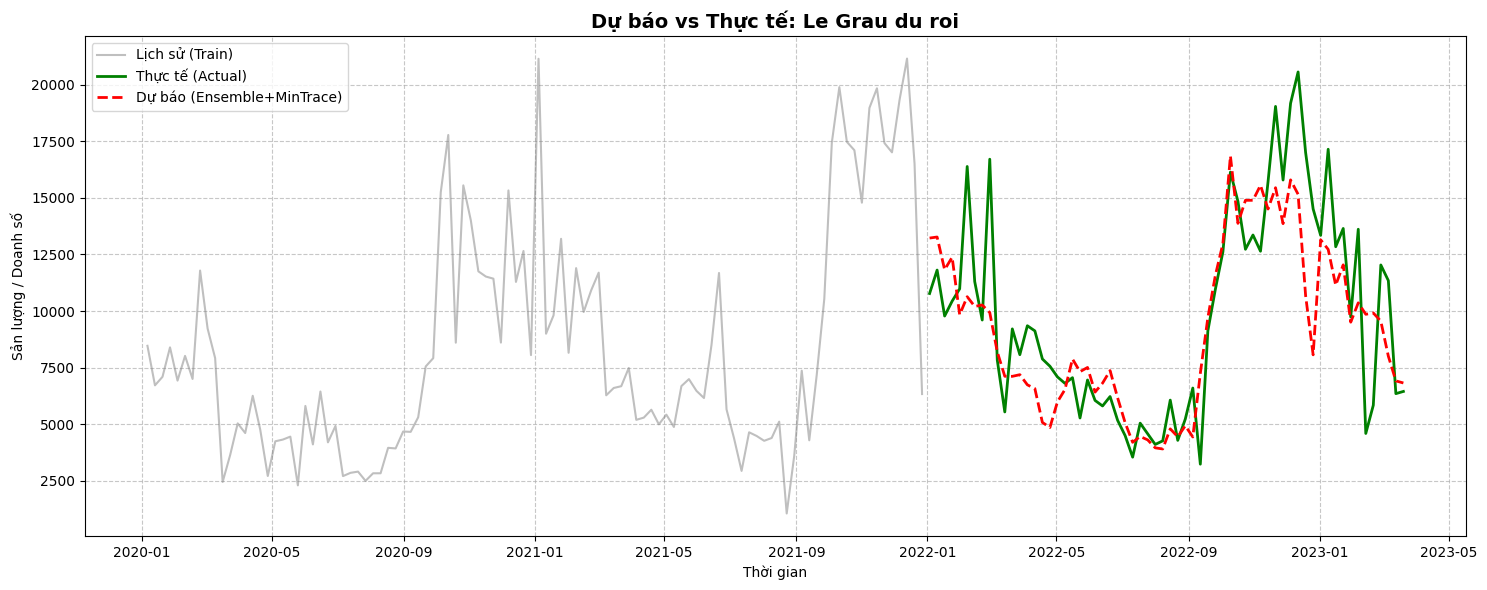


--- BIỂU ĐỒ 2: MỘT SẢN PHẨM CỤ THỂ (Cấp đáy) ---


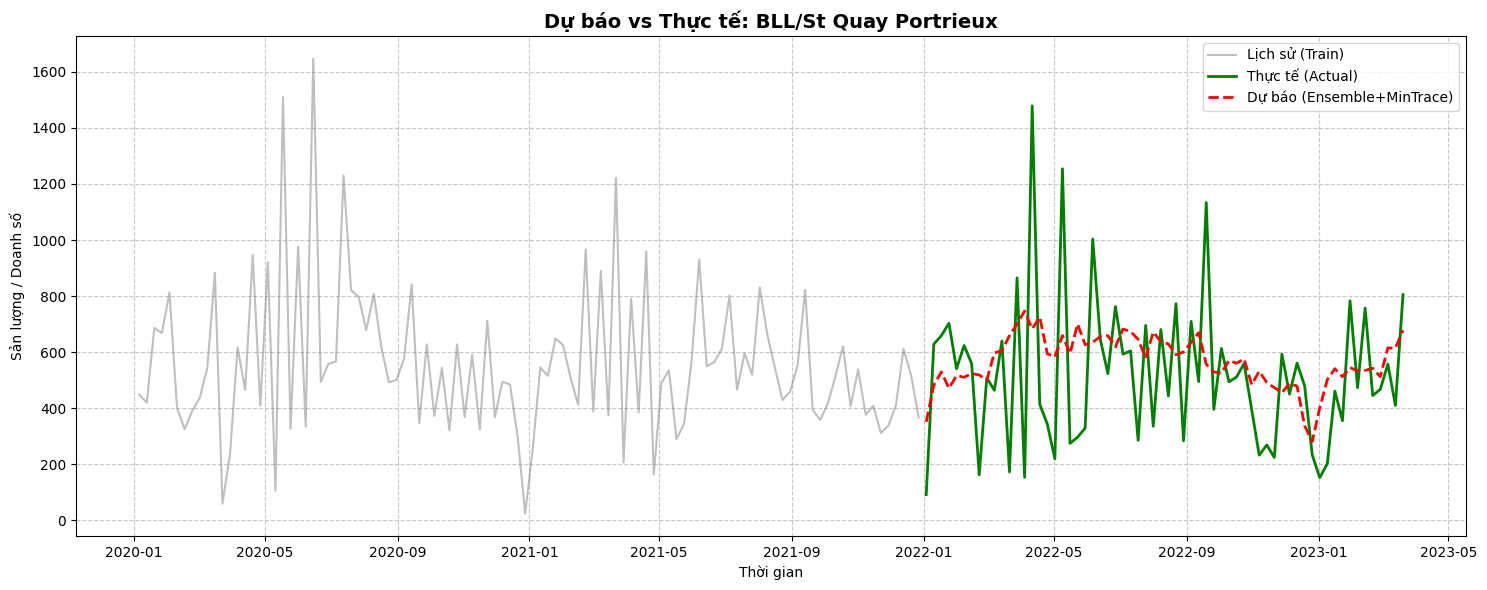


--- BIỂU ĐỒ 3: MỘT LOẠI HÀNG (Cấp trên) ---


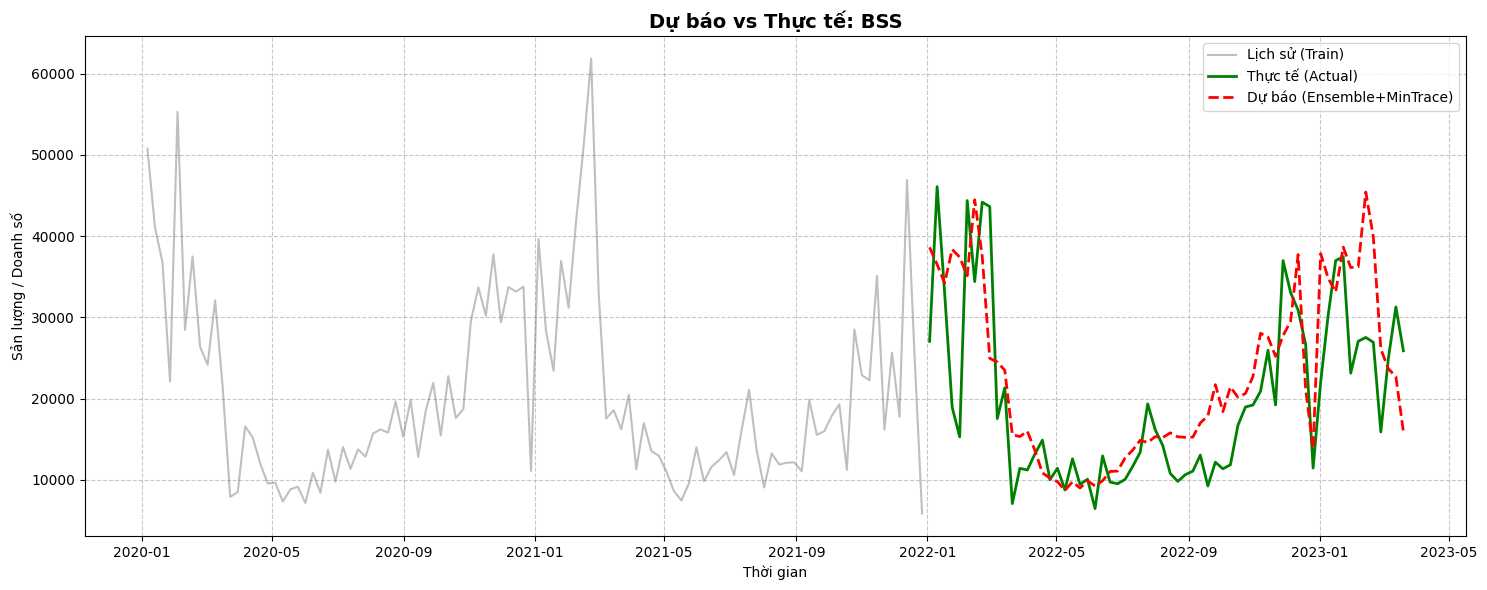

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

model_col = 'Ensemble/MinTrace_method-mint_shrink' 

# 2. Hàm vẽ biểu đồ
def plot_forecast(unique_id, Y_train, Y_test, Y_rec, model_col, lookback_weeks=52):

    train_subset = Y_train[Y_train['unique_id'] == unique_id].copy()
    test_subset = Y_test[Y_test['unique_id'] == unique_id].copy()
    rec_subset = Y_rec[Y_rec['unique_id'] == unique_id].copy()
    
    if len(train_subset) > lookback_weeks:
        train_subset = train_subset.iloc[-lookback_weeks:]
    
    plt.figure(figsize=(15, 6))
    
    # Vẽ Lịch sử (Train)
    plt.plot(train_subset['ds'], train_subset['y'], label='Lịch sử (Train)', color='gray', alpha=0.5)
    
    # Vẽ Thực tế (Test - Ground Truth)
    plt.plot(test_subset['ds'], test_subset['y'], label='Thực tế (Actual)', color='green', linewidth=2)
    
    # Vẽ Dự báo (Forecast - Model)
    # Lưu ý: Sắp xếp lại theo thời gian để vẽ liền mạch
    rec_subset = rec_subset.sort_values('ds')
    plt.plot(rec_subset['ds'], rec_subset[model_col], label='Dự báo (Ensemble+MinTrace)', 
             color='red', linestyle='--', linewidth=2)
    
    plt.title(f"Dự báo vs Thực tế: {unique_id}", fontsize=14, fontweight='bold')
    plt.xlabel("Thời gian")
    plt.ylabel("Sản lượng / Doanh số")
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


print("--- BIỂU ĐỒ 1: MỘT NHÀ ĐẤU GIÁ (Cấp giữa) ---")
sample_house = tags['AuctionHouse'][2] 
plot_forecast(sample_house, Y_train, Y_test, Y_rec_df, model_col, lookback_weeks=104)

print("\n--- BIỂU ĐỒ 2: MỘT SẢN PHẨM CỤ THỂ (Cấp đáy) ---")
sample_bottom = tags['FAO_Code/AuctionHouse'][2]
plot_forecast(sample_bottom, Y_train, Y_test, Y_rec_df, model_col, lookback_weeks=104)

print("\n--- BIỂU ĐỒ 3: MỘT LOẠI HÀNG (Cấp trên) ---")
sample_category = tags['FAO_Code'][2]
plot_forecast(sample_category, Y_train, Y_test, Y_rec_df, model_col, lookback_weeks=104)

In [ ]:
# import joblib
# import os

# # Tạo thư mục chứa model
# MODEL_DIR = "model_artifacts"
# os.makedirs(MODEL_DIR, exist_ok=True)

# joblib.dump(fcst, os.path.join(MODEL_DIR, 'fcst_model.pkl'))

# joblib.dump(S_df, os.path.join(MODEL_DIR, 'S_df.pkl'))
# joblib.dump(tags, os.path.join(MODEL_DIR, 'tags.pkl'))

# joblib.dump(Y_train, os.path.join(MODEL_DIR, 'Y_train_history.pkl'))

# print(f"✅ Đã đóng gói mô hình thành công vào thư mục: {MODEL_DIR}")

# # Hiển thị các file đã lưu
# print("\n📦 Các file trong model_artifacts:")
# for file in sorted(os.listdir(MODEL_DIR)):
#     file_path = os.path.join(MODEL_DIR, file)
#     if os.path.isfile(file_path):
#         size_mb = os.path.getsize(file_path) / (1024 * 1024)
#         print(f"  - {file}: {size_mb:.2f} MB")


✅ Đã đóng gói mô hình thành công vào thư mục: model_artifacts

📦 Các file trong model_artifacts:
  - S_df.pkl: 0.02 MB
  - Y_train_history.pkl: 0.81 MB
  - fcst_model.pkl: 0.93 MB
  - tags.pkl: 0.00 MB


In [87]:
Y_full = pd.concat([Y_train, Y_test]).sort_values(['unique_id', 'ds'])
Y_full

,unique_id,ds,y
0,BIB,2014-12-29,4523.40
1,BIB,2015-01-05,15728.00
2,BIB,2015-01-12,8191.70
3,BIB,2015-01-19,37368.02
4,BIB,2015-01-26,21823.30
...,...,...,...
28375,WHG/Lorient,2023-02-20,2281.50
28376,WHG/Lorient,2023-02-27,2562.30
28377,WHG/Lorient,2023-03-06,1599.00
28378,WHG/Lorient,2023-03-13,1257.30


In [88]:
fcst.fit(df=Y_full)

StatsForecast(models=[HW,ARIMA])

In [114]:
df_eval

,unique_id,ds,HW,ARIMA,Ensemble,HW/BottomUp,ARIMA/BottomUp,Ensemble/BottomUp,HW/MinTrace_method-ols,ARIMA/MinTrace_method-ols,Ensemble/MinTrace_method-ols,HW/MinTrace_method-mint_shrink,ARIMA/MinTrace_method-mint_shrink,Ensemble/MinTrace_method-mint_shrink,y
0,BIB,2022-01-03,18409.332261,20656.096185,19308.037830,18585.824865,19041.700459,18768.175103,18377.904548,19196.062921,18705.167897,18643.611600,18825.917607,19254.773230,26372.60
1,BIB,2022-01-10,16878.474713,16769.364180,16834.830500,16732.404607,15724.858514,16329.386170,16796.406845,16277.559284,16588.867821,17000.920243,16108.849157,16775.276052,29631.90
2,BIB,2022-01-17,18211.868834,16578.502110,17558.522145,18347.772548,15928.325292,17379.993646,18232.244187,16087.698322,17374.425841,18450.815912,16575.191230,17795.068471,19955.90
3,BIB,2022-01-24,15136.120048,15902.338632,15442.607482,15274.946468,14376.591430,14915.604453,15131.334314,15038.231756,15094.093291,15393.965071,14834.808504,15270.416568,17413.25
4,BIB,2022-01-31,13125.286365,14389.698362,13631.051164,13106.801844,13162.023759,13128.890610,13134.874716,13600.897840,13321.283965,13334.405331,13461.591054,13448.187018,20987.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,WHG/Lorient,2023-02-20,4449.640801,3824.323996,4199.514079,4449.640801,3824.323996,4199.514079,4673.235086,2977.674066,3995.010678,4775.675122,4276.925833,4346.936928,2281.50
4220,WHG/Lorient,2023-02-27,4266.913051,3824.262049,4089.852650,4266.913051,3824.262049,4089.852650,4366.514996,3568.037621,4047.124046,4441.405301,3981.602623,4158.671497,2562.30
4221,WHG/Lorient,2023-03-06,4683.315241,3824.243854,4339.686686,4683.315241,3824.243854,4339.686686,4783.097104,3537.916055,4285.024685,4871.312277,3966.534049,4339.193819,1599.00
4222,WHG/Lorient,2023-03-13,4258.175337,3824.238510,4084.600606,4258.175337,3824.238510,4084.600606,4234.567131,3645.323551,3998.869699,4298.357997,3845.956848,4044.783783,1257.30


In [109]:
Y_fitted_df_full = fcst.forecast_fitted_values()

ValueError: Length of values (24156) does not match length of index (28380)

,AuctionHouse,FAO_Code,y,ds
0,Agde,BSS,136.39,2014-12-29
1,Agde,CTC,75.63,2014-12-29
2,Agde,NSQ,462.63,2014-12-29
3,Agde,OCC,373.20,2014-12-29
4,Arcachon,BLL,128.20,2014-12-29
...,...,...,...,...
417520,Sète,SWA,47.20,2023-03-20
417521,Sète,SYC,156.80,2023-03-20
417522,Sète,TUR,26.20,2023-03-20
417523,Sète,UUC,128.20,2023-03-20
